<div align="center">
    <h1>Variational Inference and Generative Modelling Tutorial</h1>
    <h3> Weizmann AI Hub for Scientific Discovery </h3>
    <h4>Nathan LEVY</h4>
    nathan.levy@weizmann.ac.il
    <p>with inputs from N.Yosef</p>
    <p>Winter semester 2023</p>
</div>




In this tutorial, we are going to delve into a class of generative count_count_count_models called Variational Auto-Encoders. We start by stating key statistical concepts before deriving the relevant mathematical formulation. Then we build and train a VAE. \
Finally, we are going to apply the models we built to single-cell RNA-seq data, and show how these models can be used for representation learning.

💡 This tutorial does not assume prior knowledge in variational inference or biology, but does rely on basic deep learning skills, such as building and training a feedforward neural network. 

# Introduction

To begin with, let us review a few useful ML concepts. 

### Discriminative versus Generative learning


**Discriminative Learning:** \
Discriminative learning is a machine learning approach that focuses on learning the boundary or decision boundary that separates different classes or categories within the data. The primary goal of discriminative models is to find a function that directly maps the input data to the corresponding class labels. These models are designed to distinguish between different classes based on their distinct features or patterns.

A basic example of discriminative model is logistic regression, it is often used in classification tasks where the goal is to assign input data points to specific predefined categories or classes.



**Generative Learning:**\
Generative learning, on the other hand, is a machine learning approach that aims to model the underlying probability distribution of the entire dataset. Instead of focusing solely on learning the decision boundary, generative models attempt to capture the inherent structure and patterns within the data. This allows them to generate new samples that resemble the original data distribution.

Generative models can be used for various tasks, including data synthesis, image generation, and anomaly detection. Some popular generative models include Gaussian Mixture Models (GMMs), Variational Autoencoders (VAEs), and Generative Adversarial Networks (GANs).

In summary, discriminative learning only models the outputs given the inputs, while generative learning models the joint probability of inputs and outputs. 


The focus of this tutorial is on generative learning. To fit the generative models, we adopt the Bayesian inference paradigm.

### Bayesian modelling and Variational Inference


Suppose we have a probabilistic model with some parameters we want to estimate. The Bayesian paradigm involves the following key concepts:

1. **Prior Probability:** Before observing any new data, we have an initial belief about our model parameters $\theta$. This belief is expressed as the prior probability $p(\theta)$.

2. **Likelihood:** Given a dataset $D$, the likelihood function $L$ describes how likely the data is to occur given the underlying parameters: $L=p(D \mid \theta)$

3. **Posterior Probability:** After observing new data, the Bayesian approach updates the initial beliefs to incorporate information from this data. This process is called *Bayesian inference*. The updated parameters are represented as the posterior probability $p(\theta \mid D)$, which combines the prior probability and the likelihood.

4. **Evidence:** The term $p(D)$ represents the likelihood of observing the data across all possible values of the parameters or hypotheses. It acts as a normalizing constant to ensure that the posterior probability integrates to 1. The main goal of any Bayesian count_model is to optimize the evidence for the data, which is also known as the marginal likelihood. It is often more convenient to work with the log marginal likelihood.


The posterior probability is computed via the *Bayes rule*:

$$ p(\theta \mid D) = \frac{p(D|θ)p(θ)}{\int p(D|θ)p(θ)dθ} = \frac{p(D|θ)p(θ)}{p(D)}$$


However, in most models, the posterior distribution is intractable because of the integral defining the evidence, which runs over the space of all $\theta$. Therefore, the posterior must be estimated: this is called *approximate Bayesian inference*. 

There are a few popular approximate Bayesian inference methods, among which Markov Chain Monte Carlo (the idea is to construct a Markov chain that has the posterior distribution as its equilibrium distribution) and Variational Inference, which tries to minimize the distance between an approximate, tractable posterior (called the variational distribution) and the true one. We are going to focus on the latter. 


### Latent Variable Models

Given observed data $D$, Latent Variable Models assume that the data generating process is driven by unobserved *latent variables* $Z$, of smaller dimension. The latent variables should be a summary of the data, driving its variability. They can represent a useful representation of the data. 


Mixture Models are a classsic example of LVMs. They assume that the dataset $D$ is generated by sampling i.i.d. from $K$ distincts distributions called mixture components. We can describe the data generating process as follows: 

1. For each datapoint, we first sample the mixture assignment from a categorical random variable, out of $K$ possible components. 
2. Then, we sample from the assigned distribution. 

In this count_model, we do observe the datapoints, which were drawn conditionnally on the mixture assignment, but we do not observe the assignment itself: it is the latent variable. 

Given the observed data, we want to infer the latent variables, using the posterior distribution $p(Z \mid D)$. For this purpose, we'll have to rely on approximate Bayesian inference, more precisely Variational Inference. Thus we introduce the approximate posterior $q(Z \mid D)$, which comes from a family of tractable distributions. As we said, the goal is to minimize the distance between the true and approximate posterior. The common metric to use is the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). It is defined as: 
$$\mathbb{KL}(q \mid p) = \int q(x) \log \frac{q(x)}{p(x)} dx$$

The Kullback-Leibler divergence is a measure of how one probability distribution diverges from a second, expected probability distribution. In other words, it is a measure of how much information is lost when the second distribution is used to approximate the first one.

<div class="alert alert-block alert-info">
<b>Question 1</b>
Is the KL divergence symmetric? What is its value when the two distributions are equal? What is its minimum value?
</div>

### Evidence Lower Bound (ELBO)

We want to fit out latent variable count_model to the data, but the log marginal likelihood is intractable. We also want to evaluate the posterior distribution $p(Z \mid D)$, but it is also intractable, as its denominator is the evidence. Instead, we are going to maximize a lower bound on the log marginal likelihood, called the Evidence Lower Bound (ELBO).

Recall from Bayes rule that the log marginal likelihood can be written as:
$$\log p(D) = \log\frac{p(D \mid Z)p(Z)}{p(Z \mid D)} = \mathbb{E}_{Z \sim q} \left[ \log\frac{p(D \mid Z)p(Z)}{p(Z \mid D)} \right]$$

Taking the expectation with respect to the approximate posterior $q(Z \mid D)$, we get:

$$\log \left[ p(D) \right] = \mathbb{E}_{Z \sim q} \left[ \log\frac{p(D \mid Z)p(Z)}{p(Z \mid D)} \right]$$

Multiplying and dividing by $q(Z \mid D)$, we get:

$$\log \left[ p(D) \right] = \mathbb{E}_{Z \sim q} \left[ \log\frac{p(D \mid Z)p(Z)}{p(Z \mid D)} \frac {q(Z|D)}{q(Z|D)} \right]$$

Thus we can decompose the log marginal likelihood as follows:

$$\log p(D) = \mathbb{E}_{Z \sim q} \log \frac{q(Z|D)}{p(Z|D)} + \mathbb{E}_{Z \sim q} \log \frac{p(Z)}{q(Z|D)} + \mathbb{E}_{Z \sim q} \log p(D | Z)$$

This can be re-expressed using the KL divergence as follows:

$$\log p(D) = \mathbb{KL}(q(Z | D) \| p(Z | D)) - \mathbb{KL}(q(Z | D) \| p(Z)) + \mathbb{E}_{Z \sim q} \log p(D|Z)$$

Because the KL divergence is always positive, we get the following inequality:
$$\log p(D) \geq - \mathbb{KL}(q(Z | D) \| p(Z)) + \mathbb{E}_{Z \sim q} \log p(D|Z)$$

The right-hand side of the inequality is called the Evidence Lower Bound [(ELBO)](https://en.wikipedia.org/wiki/Evidence_lower_bound). It is a lower bound on the log marginal likelihood. By maximizing the ELBO, we avoid the intractability of the log marginal likelihood. 

$$ELBO =  - \mathbb{KL}(q(Z | D) \| p(Z)) + \mathbb{E}_{Z \sim q} \log p(D|Z)$$

The ELBO includes two sets of parameters: the parameters  $\phi$ of the approximate posterior $q$ and the parameters  $\theta$ of likelihood $p$.

### Deep Generative Models (DGMs)

Deep generative models are generative models that assume that both distributions $q$ and $p$ are parameterized by neural networks.
Variational Autoencoders (VAEs) are a class of DGMs with two key components: an encoder and a decoder. The encoder maps the input data to a latent representation, while the decoder maps the latent representation back to the input space. The encoder $f_\phi$ and decoder $f_\theta$ are trained jointly to maximize the ELBO.

A typical choice for the latent prior $p(Z)$ is the standard isotropic Gaussian $\mathcal{N}(0,I)$, while the appoximate posterior can be chosen as diagonal Gaussian
$$q(Z \mid D) = \mathcal{N}(\mu_\phi(D), \sigma_\phi(D))$$

such that:

$$\mu_\phi(D), \sigma_\phi(D) = f_\phi(D)$$

Where $f_\phi$ is a neural network with parameters $\phi$ and $\sigma_\phi(D)$ is a diagonal covariance matrix with zero off-diagonal elements.

With these choices, the KL divergence term in the ELBO can be computed in closed form.
The form of decoder distribution changes with the type of data we want to model. For example, if we want to model binary data, we can use a Bernoulli distribution for the decoder: 
$$p(D \mid Z) = \mathcal{B}(\mu_\theta(Z))$$
With $\mu_\theta(Z) = f_\theta(Z)$.

If we want to model continuous data, we can use a (diagonal) Gaussian distribution for the decoder, such that:
$$p(D \mid Z) = \mathcal{N}(\mu_\theta(Z), \sigma_\theta(Z))$$
With $\mu_\theta(Z), \sigma_\theta(Z) = f_\theta(Z)$.


Using the 3 distributions above, we can analytically compute the two ELBO terms: the KL $\mathbb{KL}(q(Z | D) \| p(Z))$ and the reconstruction term $\mathbb{E}_{Z \sim q} \log p(D|Z)$.

<div class="alert alert-block alert-info">
<b>Question 2</b>
What is the analytical expression of the KL divergence? What is the analytical expression of the reconstruction term for a Gaussian decoder? For a Bernoulli decoder?

💡 Hints: minimizing the negative Bernoulli log-likelihood is equivalent to minimizing the binary cross-entropy loss. Minimizing the negative Gaussian log-likelihood is equivalent to minimizing the mean squared error for unit variance. You may also check the VAE seminal paper https://arxiv.org/pdf/1312.6114v10.pdf. 
</div>

### Stochastic optimization of the ELBO

We want to use stochastic gradient descent to optimize the ELBO. For this purpose, we need to compute the gradient of the ELBO with respect to the parameters $\phi$ and $\theta$. However, we cannot differentiate the ELBO w.r.t. $\phi$ as we cannot directly backpropagate
gradients through the random variable $Z$. We will need to use a change of variables called the *reparametrization trick*. Please read about the trick [here](https://sassafras13.github.io/ReparamTrick/).

# Design and train a VAE

Now that we derived the mathematical formulation of the VAE, we are going to implement it. We will use the MNIST dataset, which consists of 28x28 grayscale images of handwritten digits. You can find more about the dataset [here](http://yann.lecun.com/exdb/mnist/).


The goal is to train a VAE to generate images of handwritten digits.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch
import matplotlib.pyplot as plt
import random

from tqdm import tqdm
from rich import print


from torch.optim.lr_scheduler import StepLR, ExponentialLR

Load the MNIST dataset:

In [3]:
trainset = MNIST(
    root="./vae_data", train=True, download=True, transform=transforms.ToTensor()
)
testset = MNIST(
    root="./vae_data", train=False, download=True, transform=transforms.ToTensor()
)

Plot a random item:

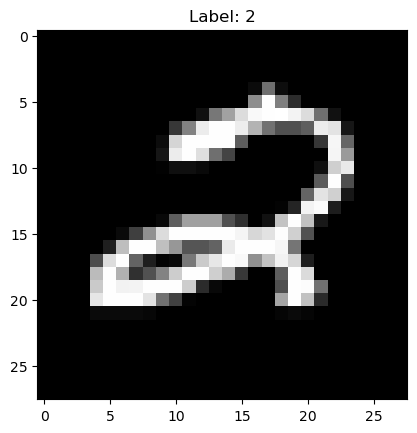

In [4]:
# Get a random image and its label
index = random.randint(0, len(trainset) - 1)
image, label = trainset[index]

# Convert the tensor to a NumPy array for visualization
image = image.numpy()

# Plot the random image
plt.imshow(image[0], cmap="gray")
plt.title(f"Label: {label}")
plt.show()

Build the train/test dataloaders:

In [5]:
BATCH_SIZE = 128

In [6]:
train_dataloader = DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)
test_dataloader = DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)

#### Build the Encoder and the Decoder:


To make use of the reparameterization trick, you should use the rsample method of torch.distributions.Normal. This method returns a sample from the distribution, with gradients flowing through the mean and standard deviation. You can have a look at the documentation [here](https://pytorch.org/docs/stable/distributions.html). 

<div class="alert alert-block alert-info">
<b>Question 3</b>
Complete the code below to build the encoder and the decoder.
</div>

You are free to use whatever you prefer to build the model layers, but we provide you with a helper function, with default ReLU and BatchNorm layers.

In [7]:
from utils import make_layer

# example usage of make_layer

# input_size = 784
# hidden_sizes = [256, 128]
# output_size = 2

# layer_sizes = [input_size, *hidden_sizes, output_size]

# layers = torch.nn.Sequential(
#     *[
#         make_layer(
#             in_dim=in_size,
#             out_dim=out_size,
#         )
#         for (in_size, out_size) in zip(layer_sizes[:-1], layer_sizes[1:])
#     ]
# )

In [8]:
class Encoder(nn.Module):

    """
    Encoder network for the VAE.
    """

    def __init__(
        self,
        n_input: int,
        n_output: int,
        hidden_sizes: list = [256, 128],
    ):
        super().__init__()

        # ------------------------------WRITE YOUR CODE---------------------------------#
        # encode a data point. This should return couple of tensors (mu, logvar) representing
        # the mean and the log variance of the Gaussian q(Z | X)

        layer_sizes = [n_input, *hidden_sizes]

        self.encoder = torch.nn.Sequential(
            *[
                make_layer(
                    in_dim=in_size,
                    out_dim=out_size,
                )
                for (in_size, out_size) in zip(layer_sizes[:-1], layer_sizes[1:])
            ]
        )

        self.mu = nn.Linear(hidden_sizes[-1], n_output)
        self.log_var = nn.Linear(hidden_sizes[-1], n_output)

    def forward(self, x):
        # ------------------------------WRITE YOUR CODE---------------------------------#
        # generate mu and log_var from x, then sample z from the distribution N(mu, log_var) using rsample() method.

        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)

        var = torch.nn.Softplus()(log_var)

        latent_dist = torch.distributions.Normal(mu, var.sqrt())

        latent_sample = latent_dist.rsample()

        return latent_dist, latent_sample

In [9]:
class Decoder(nn.Module):

    """
    Decoder network for the VAE.
    """

    def __init__(
        self,
        n_input: int,
        n_output: int,
        hidden_sizes: list = [128, 256],
    ):
        super().__init__()

        layer_sizes = [n_input, *hidden_sizes]

        # ------------------------------WRITE YOUR CODE---------------------------------#
        # decode a latent variable. This should return a tensor representing the mean of the
        # Bernoulli distribution p(X | Z)

        self.decoder = torch.nn.Sequential(
            *[
                make_layer(
                    in_dim=in_size,
                    out_dim=out_size,
                )
                for (in_size, out_size) in zip(layer_sizes[:-1], layer_sizes[1:])
            ]
        )

        self.mean = nn.Linear(hidden_sizes[-1], n_output)

    def forward(self, z):
        # ------------------------------WRITE YOUR CODE---------------------------------#
        # generate mean from z

        z = self.decoder(z)

        mean = torch.sigmoid(self.mean(z))

        dist = torch.distributions.Bernoulli(mean)

        return dist


class PoissonDecoder(Decoder):

    """
    Decoder network for the Poisson VAE.
    """

    def __init__(
        self,
        n_input: int,
        n_output: int,
        hidden_sizes: list = [128, 256],
    ):
        super().__init__(n_input, n_output, hidden_sizes)

    def forward(self, z):
        # ------------------------------WRITE YOUR CODE---------------------------------#
        # generate mean from z

        z = self.decoder(z)

        mean = torch.nn.Softplus()(self.mean(z))

        dist = torch.distributions.Poisson(mean)

        return dist

In [10]:
class VAE(nn.Module):

    """
    Variational Autoencoder.
    """

    def __init__(
        self,
        n_input: int,
        n_output: int,
        hidden_sizes_encoder: list = [256, 128],
        hidden_sizes_decoder: list = [128, 256],
        latent_dim: int = 2,
        likelihood: str = "bernoulli",
    ):
        super().__init__()

        self.likelihood = likelihood

        self.encoder = Encoder(n_input, latent_dim, hidden_sizes_encoder)
        if likelihood == "bernoulli":
            self.decoder = Decoder(latent_dim, n_output, hidden_sizes_decoder)
        elif likelihood == "poisson":
            self.decoder = PoissonDecoder(latent_dim, n_output, hidden_sizes_decoder)

    def forward(self, x):
        # ------------------------------WRITE YOUR CODE---------------------------------#
        # generate mu and log_var from x, then sample z from the distribution N(mu, log_var) using rsample() method.
        # generate mean from z

        latent_dist, latent_sample = self.encoder(x)
        obs_dist = self.decoder(latent_sample)

        return obs_dist, latent_dist

#### Train the model

<div class="alert alert-block alert-info">
<b>Question 4</b>
Complete the code below to train the model. You should use the analytical expressions of the KL divergence and the reconstruction term that you derived in Question 2.
</div>

In [11]:
LATENT_DIM = 10

N_EPOCHS = 5
LR = 0.001
KL_weight = 0.1

DEVICE = "cuda:0"

In [12]:
from utils import dkl

In [13]:
model = VAE(28 * 28, 28 * 28, hidden_sizes_encoder=[128], hidden_sizes_decoder=[128])

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=1e-5)
# optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)

# scheduler = StepLR(optimizer, step_size=10, gamma=0.2)
scheduler = ExponentialLR(optimizer, gamma=0.99)

# optimizer = torch.optim.Adam(
#     model.parameters(), lr=LR
# )

train_kl, train_recon = [], []
val_kl, val_recon = [], []

for epoch in tqdm(range(N_EPOCHS)):
    model.train()

    for x, _ in train_dataloader:
        optimizer.zero_grad()

        x_input = x.view(-1, 28 * 28)

        p_x, q_z = model(x_input)

        # ------------------------------WRITE YOUR CODE---------------------------------#
        # compute the KL part of the ELBO loss here

        # kl_loss = dkl(q_z).sum(axis=1).mean()
        kl_loss = (
            torch.distributions.kl_divergence(q_z, torch.distributions.Normal(0, 1))
            .sum(axis=1)
            .mean()
        )

        # ------------------------------WRITE YOUR CODE---------------------------------#
        # compute the reconstruction part of the ELBO loss here

        # recon_loss = torch.nn.functional.binary_cross_entropy(
        #     x_mean, x_input, reduction="mean"
        # )

        if model.likelihood == "bernoulli":
            recon_loss = torch.nn.functional.binary_cross_entropy(
                p_x.mean, x_input, reduction="mean"
            )

        if model.likelihood == "poisson":
            recon_loss = -p_x.log_prob(x_input).mean()

        # ------------------------------WRITE YOUR CODE---------------------------------#
        # compute the ELBO loss here

        loss = KL_weight * kl_loss + recon_loss
        loss.backward()
        optimizer.step()

        train_kl.append(kl_loss.item())
        train_recon.append(recon_loss.item())

    scheduler.step()

    if epoch % 1 == 0:
        with torch.no_grad():
            model.eval()

            for x, _ in test_dataloader:
                x_input = x.view(-1, 28 * 28)

                p_x, q_z = model(x_input)

                kl_loss = dkl(q_z).sum(axis=1).mean()

                if model.likelihood == "bernoulli":
                    recon_loss = torch.nn.functional.binary_cross_entropy(
                        p_x.mean, x_input, reduction="mean"
                    )

                if model.likelihood == "poisson":
                    recon_loss = -p_x.log_prob(x_input).mean()

                val_kl.append(kl_loss.item())
                val_recon.append(recon_loss.item())

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:27<00:00,  5.49s/it]


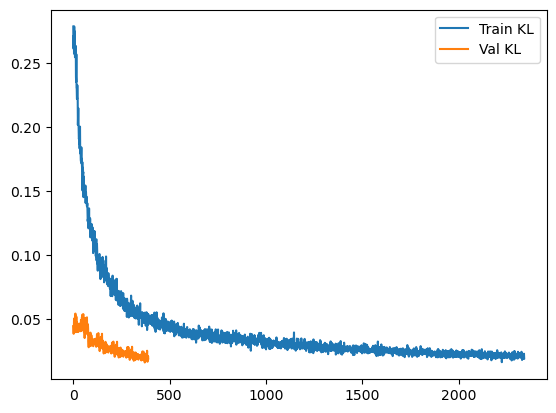

In [14]:
plt.plot(train_kl, label="Train KL")
plt.plot(val_kl, label="Val KL")
plt.legend()
plt.show()

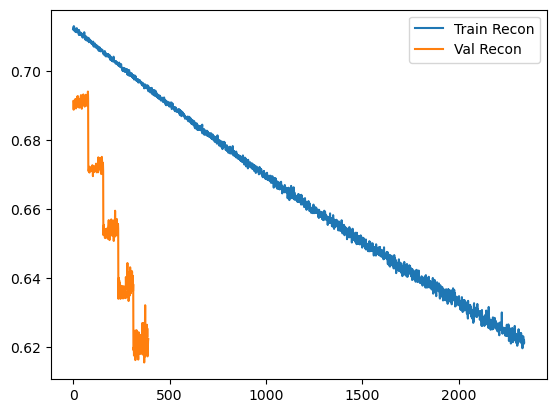

In [15]:
plt.plot(train_recon, label="Train Recon")
plt.plot(val_recon, label="Val Recon")
plt.legend()
plt.show()

# Applying DGMs to sc-RNA-seq data

In [16]:
import anndata
from anndata.experimental import AnnLoader

import scvi
import scanpy as sc
import numpy as np

In [17]:
adata = scvi.data.heart_cell_atlas_subsampled(save_path="./")
print(adata)

INFO     File ./hca_subsampled_20k.h5ad already downloaded                                                         


AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 
'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 
'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 
'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

In [18]:
adata.layers["counts"] = adata.X.copy()

In [19]:
sc.pp.filter_genes(adata, min_counts=5)
sc.pp.filter_cells(adata, min_counts=5)
sc.pp.normalize_total(adata, target_sum=1e4)

adata.raw = adata

In [20]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

In [21]:
n_cells = len(adata)
frac_train = 0.8

train_index = np.random.choice(n_cells, size=int(frac_train * n_cells), replace=False)

train_mask = np.empty(shape=(n_cells,), dtype=bool)

train_mask[:] = False
train_mask[train_index] = True
test_mask = np.logical_not(train_mask)

adata_train = adata[train_mask].copy()
adata_test = adata[test_mask].copy()

print("#train cells: ", len(adata_train))
print("#test cells: ", len(adata_test))

train_dataloader = AnnLoader(adata_train, shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = AnnLoader(adata_test, shuffle=True, batch_size=BATCH_SIZE)

#train cells:  14912

#test cells:  3729

In [22]:
count_model = VAE(
    adata.n_vars,
    adata.n_vars,
    hidden_sizes_encoder=[128],
    hidden_sizes_decoder=[128],
    latent_dim=LATENT_DIM,
    likelihood="poisson",
)

count_model = count_model.to(DEVICE)

optimizer = torch.optim.SGD(
    count_model.parameters(), lr=LR, momentum=0.9, weight_decay=1e-5
)
# optimizer = Lion(count_model.parameters(), lr=1e-4, weight_decay=1e-2)
# optimizer = torch.optim.Adam(
#     count_model.parameters(), lr=LR
# )

# scheduler = StepLR(optimizer, step_size=10, gamma=0.2)
scheduler = ExponentialLR(optimizer, gamma=0.99)

train_kl, train_recon = [], []
val_kl, val_recon = [], []

n_cells_train = BATCH_SIZE * len(train_dataloader)
n_cells_test = BATCH_SIZE * len(test_dataloader)

for epoch in tqdm(range(N_EPOCHS)):
    count_model.train()

    for batch in train_dataloader:
        train_kl_epoch, train_recon_epoch = 0, 0

        optimizer.zero_grad()

        x_input = batch.layers["counts"].to(DEVICE)

        p_x, q_z = count_model(x_input)

        # ------------------------------WRITE YOUR CODE---------------------------------#
        # compute the KL part of the ELBO loss here

        # kl_loss = dkl(q_z).sum(axis=1).mean()
        kl_loss = (
            torch.distributions.kl_divergence(q_z, torch.distributions.Normal(0, 1))
            .sum(axis=1)
            .sum()
        )

        # ------------------------------WRITE YOUR CODE---------------------------------#
        # compute the reconstruction part of the ELBO loss here

        recon_loss = -p_x.log_prob(x_input).sum()

        # ------------------------------WRITE YOUR CODE---------------------------------#
        # compute the ELBO loss here

        loss = KL_weight * kl_loss + recon_loss
        loss.backward()
        optimizer.step()

        train_kl_epoch += kl_loss.item()
        train_recon_epoch += recon_loss.item()

    train_kl.append(train_kl_epoch / n_cells_train)
    train_recon.append(train_recon_epoch / n_cells_train)

    scheduler.step()

    if epoch % 1 == 0:
        with torch.no_grad():
            val_kl_epoch, val_recon_epoch = 0, 0
            count_model.eval()

            for batch in test_dataloader:
                x_input = batch.layers["counts"].to(DEVICE)

                p_x, q_z = count_model(x_input)

                kl_loss = (
                    torch.distributions.kl_divergence(
                        q_z, torch.distributions.Normal(0, 1)
                    )
                    .sum(axis=1)
                    .mean()
                )

                recon_loss = -p_x.log_prob(x_input).mean()

                val_kl_epoch += kl_loss.item()
                val_recon_epoch += recon_loss.item()

    val_kl.append(val_kl_epoch / n_cells_test)
    val_recon.append(val_recon_epoch / n_cells_test)

  0%|          | 0/5 [00:00<?, ?it/s]


ValueError: Expected parameter loc (Tensor of shape (128, 10)) of distribution Normal(loc: torch.Size([128, 10]), scale: torch.Size([128, 10])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward0>)